# IO

In [1]:
from PineBioML.preprocessing import IO

In [2]:
# Path
input_folder = "./input/"
output_folder = "./output/"
export_title = "example_basic "

In [3]:
##### Read data method 1: read single file
##### index_col is the column of index of samples (or sample name).
##### If your data do not have such column, please set index_col=None
data = IO.read_file(input_folder+ "example_data.xlsx", index_col=0)

##### pick the target label column
y = data["y"]

##### drop the target from dataframe, using the remaining to predict y (the target)
x = data.drop("y", axis = 1)

In [4]:
##### Read data method 2: read multiple files
x, y = IO.read_multiple_files(
    file_path_list=[
        input_folder+ "example_group1.csv", # all samples from this file will have y = 0, because it is in the 1st place of the file path list.
        input_folder+ "example_group2.tsv", # all samples from this file will have y = 1, because it is in the 2nd place of the file path list.
    ],
    index_col=0
    )

In [5]:
x.head(5)

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature90,feature91,feature92,feature93,feature94,feature95,feature96,feature97,feature98,feature99
0,-0.046497,-0.936589,0.831728,0.676612,1.089821,1.182193,0.057498,1.087513,0.916977,1.366645,...,-0.906979,0.557050,-0.052619,-0.777292,1.332989,0.586623,0.755015,0.568341,0.557208,-0.301866
1,1.375768,2.982642,0.828336,0.331314,0.780520,0.077063,-0.180034,0.720076,-0.293831,1.130501,...,1.706683,0.370087,-1.770032,1.021724,-1.395205,1.358890,-0.242389,-1.181098,-1.395800,-1.978847
2,0.513176,-0.237153,0.403565,0.340722,-0.969333,1.181883,-1.853352,0.954555,0.102275,-0.966393,...,-0.287969,0.243530,-0.684112,0.179854,-1.024727,0.962608,-0.246234,-1.125735,-1.121738,-0.757847
3,-0.113984,0.570842,-1.447456,0.478515,-1.063417,-0.928786,-0.903156,-0.163331,-0.231151,0.136662,...,-0.299377,1.624747,0.046088,-0.585543,-2.059056,-0.872338,-0.491621,-0.383596,1.557598,-0.923839
4,1.338395,1.014111,-0.231040,0.188683,1.030870,0.233220,1.318331,-1.253098,-2.084681,0.360878,...,-0.284378,-0.145813,-0.264684,0.399323,0.629979,0.410857,-1.790606,-0.511627,0.539162,1.026244


In [6]:
y.head(5)

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
dtype: float64

# Preprocessing

In [7]:
### within sample normalization
#x = x.T
#x = (x-x.mean())/x.std()
#x = x.T

### standarization
x = (x-x.mean())/x.std()

In [8]:
# Impute 0
from PineBioML.preprocessing import impute

# The imputer will drop the features with missing value more than 60%.
# Remaining will be filled by 0.
simple = impute.simple_imputer(threshold = 0.6, strategy = "constant")
x, y = simple.fit_transform(x, y)

# Data overview

In [9]:
import PineBioML.report.utils as report_utils

The x consists of of 1 useful feature and 99 garbage features.

start PCA
start PLS
start UMAP


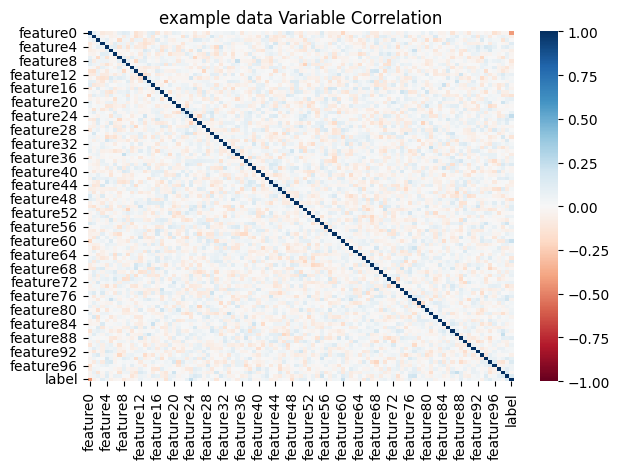

example data PCA Scatter plot


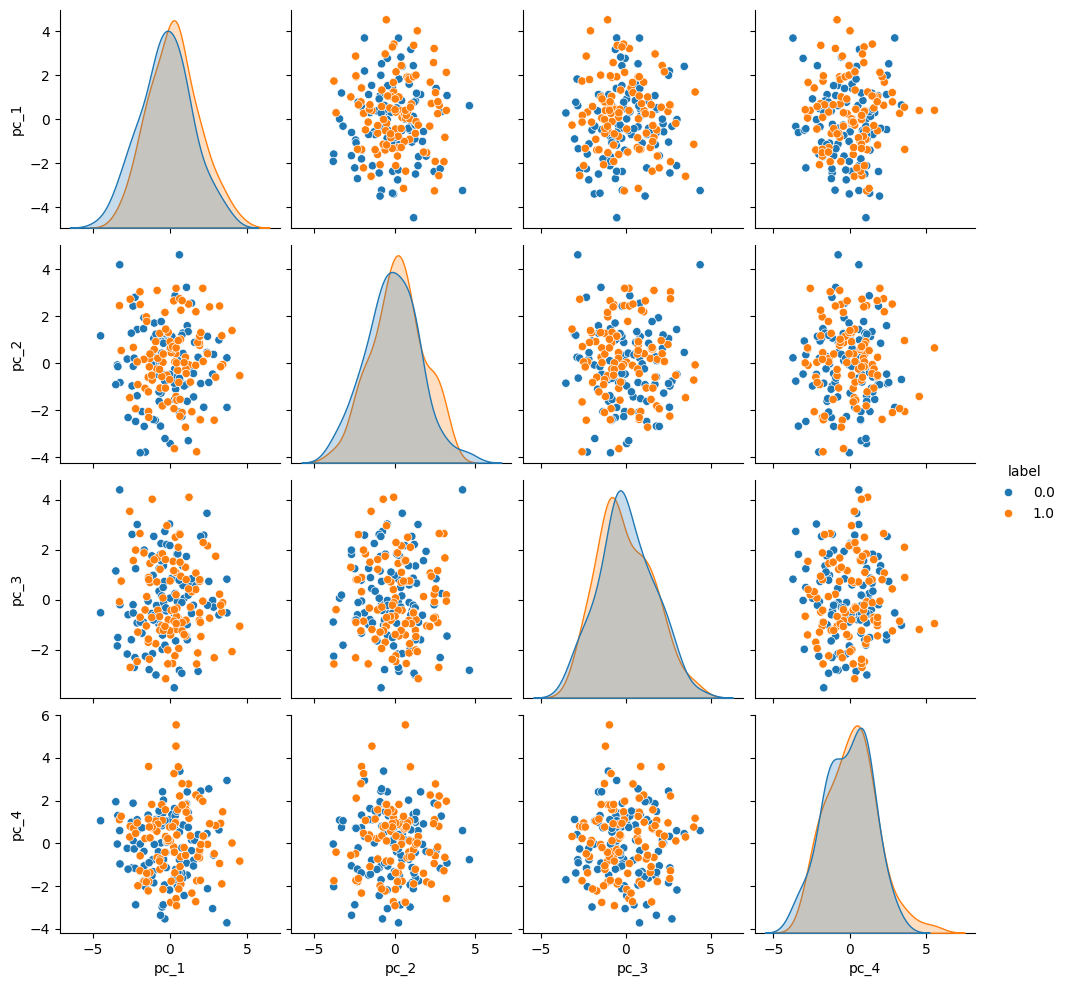

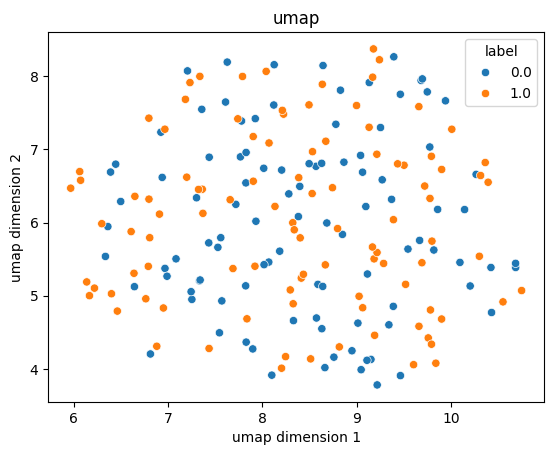

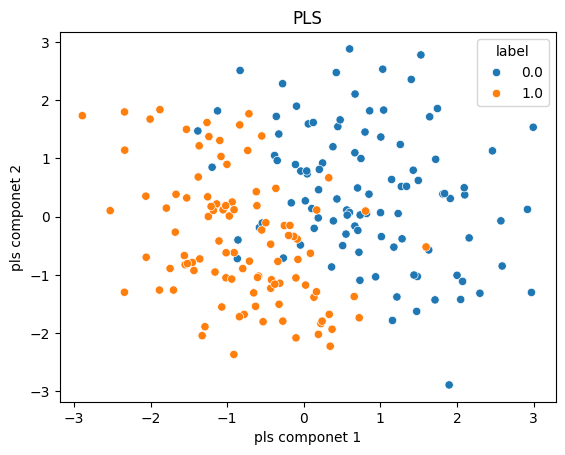

In [10]:
report_utils.data_overview(x, y, label_name = "label", title= "example data")

# Feature selection

In [11]:
from PineBioML.selection.ensemble import selector

In [12]:
# Use several way to select top-k important features, which includes decision tree, random forest, lasso, multi lasso, svm, adaboost, xgboost
ensemble_selector = selector()
important_feature, importance = ensemble_selector.Select(x, y, k = 20) # if k = -1, it returns all the feature scores

Using  c45  to select.


100%|██████████| 100/100 [00:00<00:00, 432.69it/s]


c45  is done.

Using  RF_gini  to select.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1024 out of 1024 | elapsed:    1.0s finished


RF_gini  is done.

Using  AdaBoost  to select.
I don't have a progress bar but I am running
AdaBoost  is done.

Using  Lasso_Bisection  to select.
Lasso_Bisection  is done.

Using  multi_Lasso  to select.
multi_Lasso  is done.

Using  SVM  to select.
SVM  is done.

Using  XGboost  to select.
XGboost  is done.

Using  Lightgbm  to select.
[LightGBM] [Info] Number of positive: 100, number of negative: 100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6829
[LightGBM] [Info] Number of data points in the train set: 200, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [13]:
# The features that was selected by ML algoritms.
important_feature

,DT_score_c45,RandomForest_gini,AdaBoost128,LassoLinear,multi_Lasso,SVM,XGboost,Lightgbm
0,feature0,feature0,feature0,feature0,feature0,feature0,feature95,feature0
1,feature11,feature24,feature24,feature24,feature24,feature18,feature0,feature18
2,feature59,feature60,feature66,feature18,feature18,feature66,feature60,feature60
3,feature88,feature66,feature18,feature66,feature60,feature24,feature76,feature38
4,feature36,feature48,feature60,feature60,feature48,feature47,feature66,feature11
5,feature25,feature18,feature38,feature95,feature66,feature95,feature5,feature24
6,feature27,feature38,NaN,feature30,feature8,feature34,feature10,feature65
7,feature35,feature30,NaN,feature51,feature88,feature76,feature38,feature95
8,feature46,feature59,NaN,feature88,feature76,feature43,feature29,feature66
9,feature60,feature88,NaN,feature16,feature3,feature27,feature44,feature47


In [14]:
# The feature importance given by diffirent methods.
# Please Notice that the score between diffirent methods is not comparable.
importance

,DT_score_c45,RandomForest_gini,AdaBoost128,LassoLinear,multi_Lasso,SVM,XGboost,Lightgbm
feature0,0.069869,0.078257,0.781250,0.170455,0.149398,0.062260,0.032218,95.0
feature11,0.033512,0.011240,NaN,NaN,NaN,NaN,NaN,16.0
feature59,0.032971,0.013188,NaN,NaN,NaN,NaN,0.017908,NaN
feature88,0.032788,0.012714,NaN,0.011126,0.009941,NaN,NaN,NaN
feature36,0.031090,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feature25,0.030408,NaN,NaN,NaN,0.003081,NaN,NaN,NaN
feature27,0.030115,NaN,NaN,NaN,NaN,0.019073,NaN,NaN
feature35,0.030083,NaN,NaN,NaN,0.006770,NaN,NaN,NaN
feature46,0.029402,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feature60,0.029305,0.022180,0.023438,0.028461,0.018804,NaN,0.027100,17.0


In [15]:
# merging importance from diffirent feature by z-score.
merge_importance = ((importance-importance.mean())/importance.std()).mean(axis = 1).sort_values(ascending=False)
merge_importance

feature0     3.475797
feature24    0.531978
feature10    0.429697
feature95    0.285272
feature66    0.195908
feature60    0.120939
feature18    0.107631
feature36   -0.062510
feature11   -0.063597
feature5    -0.105539
feature47   -0.117556
feature76   -0.152455
feature88   -0.173142
feature34   -0.205235
feature27   -0.215457
feature38   -0.240854
feature46   -0.246733
feature35   -0.252020
feature48   -0.255059
feature33   -0.263081
feature13   -0.264263
feature8    -0.269346
feature65   -0.289199
feature25   -0.289681
feature74   -0.291774
feature41   -0.304176
feature30   -0.306792
feature73   -0.342055
feature15   -0.349053
feature44   -0.349674
feature23   -0.351515
feature59   -0.352355
feature29   -0.355224
feature4    -0.369797
feature3    -0.378575
feature43   -0.378699
feature19   -0.394076
feature91   -0.400906
feature70   -0.424355
feature99   -0.426850
feature50   -0.435682
feature12   -0.439353
feature67   -0.454749
feature75   -0.482043
feature53   -0.505469
feature49 

### Choosing the top-5 feature to build models

In [16]:
x = x[merge_importance.index[:5]]

start PCA
start PLS
start UMAP


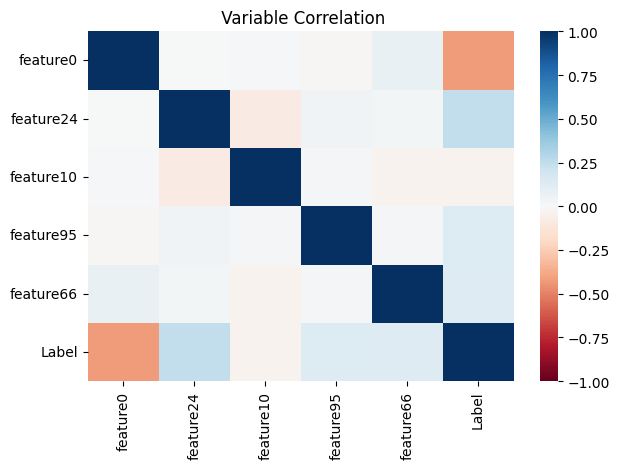

 PCA Scatter plot


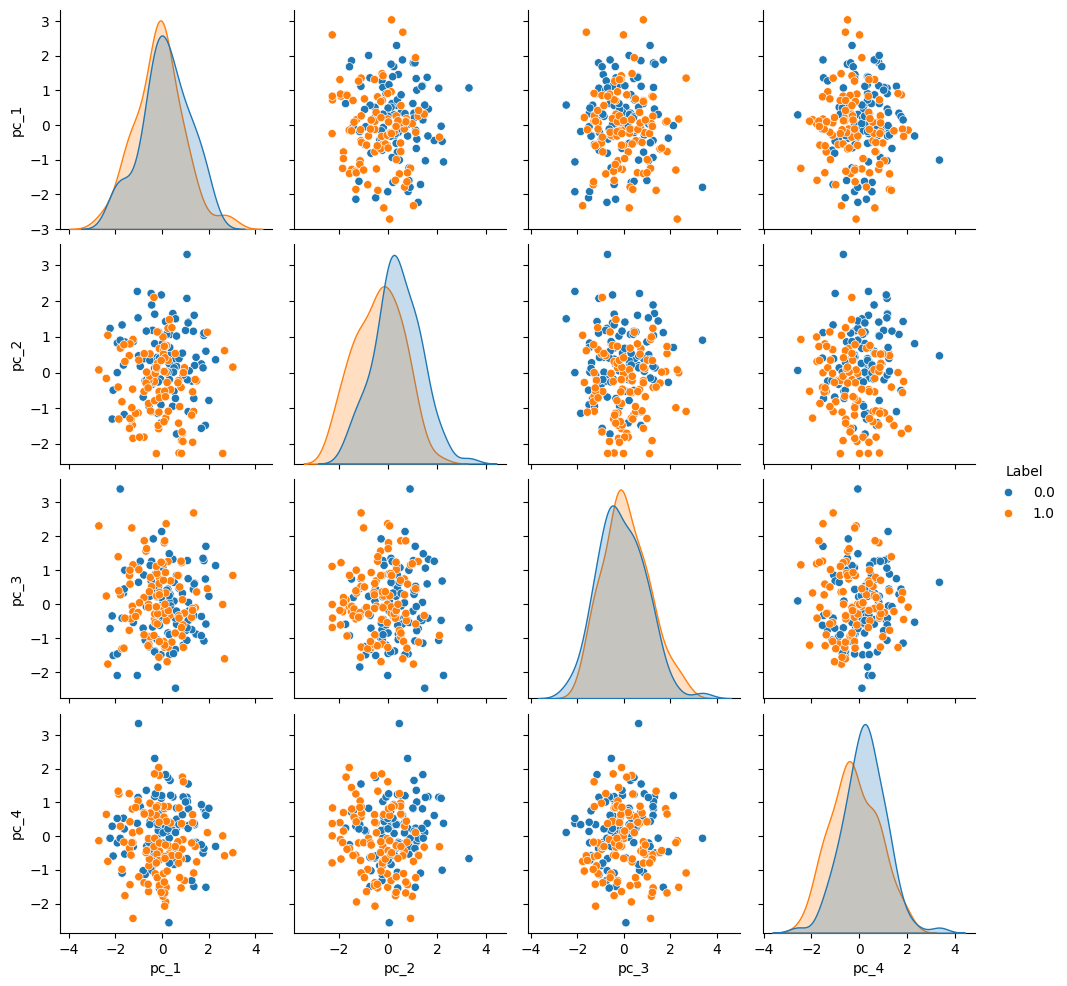

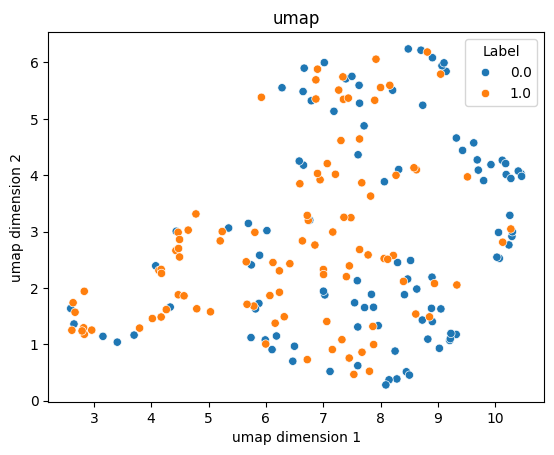

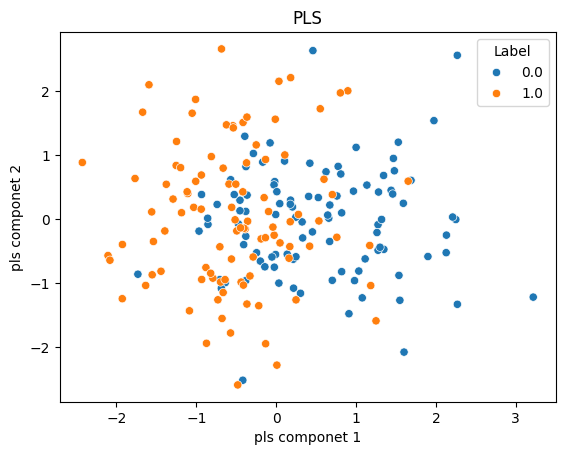

In [17]:
# Overviewing the top-5 features.
report_utils.data_overview(x, y, label_name = "Label")

# Modeling

### Train test split

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x[merge_importance.index[:5]], y, test_size=0.33, random_state=142, shuffle=True)

### Tuning a model

In [19]:
import PineBioML.model.supervised.Classification as tuner

start tuning. it will take a while.
best trial:  30   |  optuna seed:  71   |  model seed:  6422
best parameters:  {'n_estimators': 268, 'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 9, 'ccp_alpha': 0.0004045464088216161, 'max_samples': 0.6371252148133404}

 
              precision    recall  f1-score   support

         0.0       0.80      0.61      0.69        33
         1.0       0.68      0.85      0.76        33

    accuracy                           0.73        66
   macro avg       0.74      0.73      0.72        66
weighted avg       0.74      0.73      0.72        66



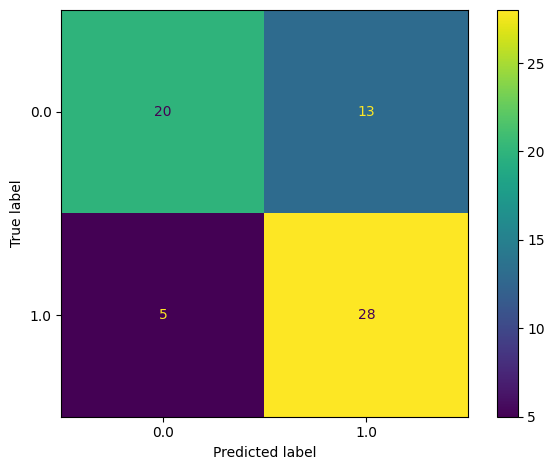

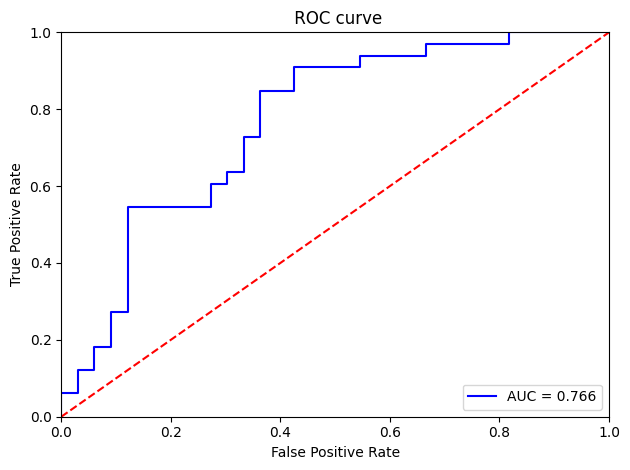

In [20]:
rf = tuner.RandomForest_tuner(target="roc_auc").tune(x_train, y_train)
rf.fit(x_train, y_train)
report_utils.classification_summary(y_valid ,rf.predict_proba(x_valid)[:, 1]) 

start tuning. it will take a while.
best trial:  20   |  optuna seed:  71   |  model seed:  4534
best parameters:  {'svc_c': 0.29813492092569305}

 
              precision    recall  f1-score   support

         0.0       0.69      0.61      0.65        33
         1.0       0.65      0.73      0.69        33

    accuracy                           0.67        66
   macro avg       0.67      0.67      0.67        66
weighted avg       0.67      0.67      0.67        66



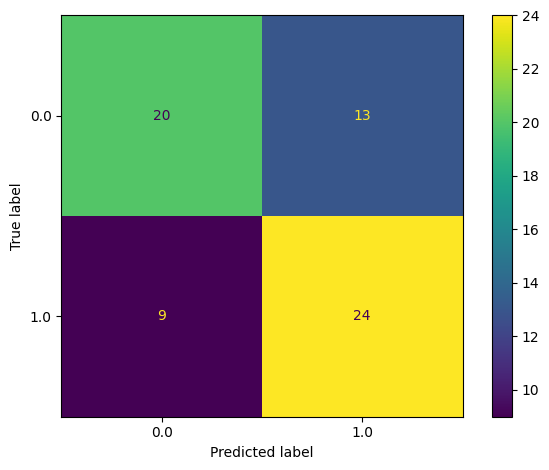

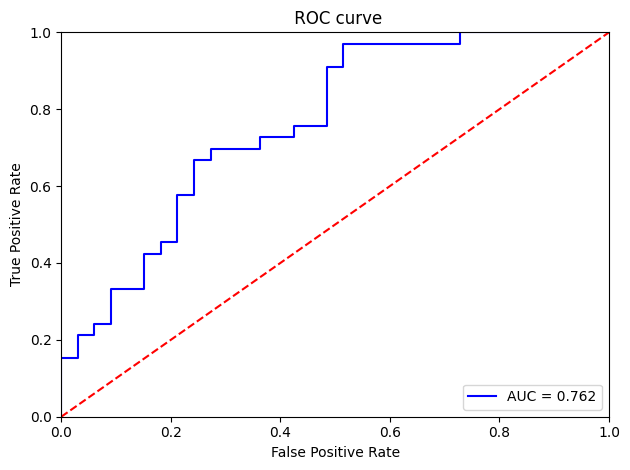

In [21]:
svm = tuner.SVC_tuner(target="f1").tune(x_train, y_train)
svm.fit(x_train, y_train)
report_utils.classification_summary(y_valid, svm.predict_proba(x_valid)[:, 1]) 

In [22]:
elastic_logistic_regression_tuner = tuner.ElasticLogit_tuner(target = "matthews_corrcoef")

elasticnet = elastic_logistic_regression_tuner.tune(x_train, y_train)
elasticnet.fit(x_train, y_train)

elastic_logistic_regression_tuner.summary()

Logistic Regression with:  elasticnet  penalty,  saga  solver.
start tuning. it will take a while.
best trial:  19   |  optuna seed:  71   |  model seed:  16064
best parameters:  {'C': 0.16380795238186316, 'l1_ratio': 0.12656981869849393}
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  134
Model:                          Logit   Df Residuals:                      129
Method:                           MLE   Df Model:                            4
Date:                Mon, 22 Jul 2024   Pseudo R-squ.:                  0.2143
Time:                        16:58:27   Log-Likelihood:                -72.973
converged:                      False   LL-Null:                       -92.882
Covariance Type:            nonrobust   LLR p-value:                 4.722e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------


 
              precision    recall  f1-score   support

         0.0       0.80      0.73      0.76        33
         1.0       0.75      0.82      0.78        33

    accuracy                           0.77        66
   macro avg       0.78      0.77      0.77        66
weighted avg       0.78      0.77      0.77        66



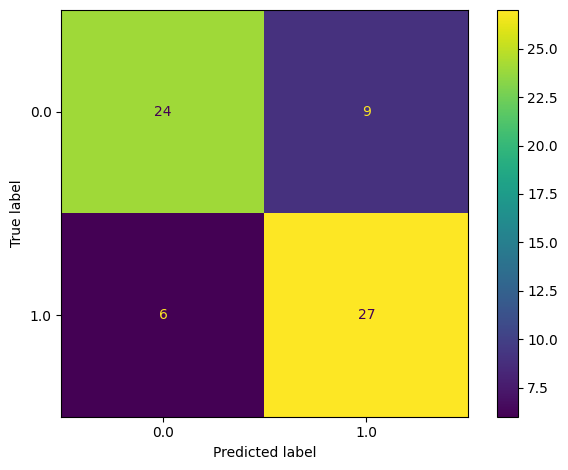

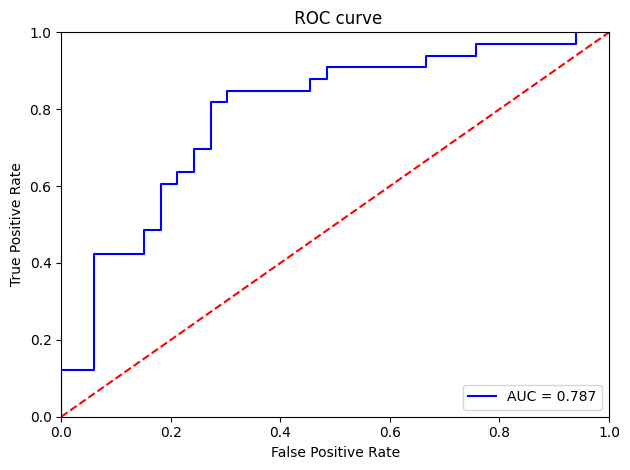

In [23]:
report_utils.classification_summary(y_valid, elasticnet.predict_proba(x_valid)[:, 1]) 

### Mljar

from supervised.automl import AutoML

mljar = AutoML(mode = "Perform", results_path = output_folder+"MLjar")
mljar.fit(x_train, y_train)

report_utils.classification_summary(y_valid, mljar.predict_proba(x_valid)[:, 1])

# Output

In [24]:
# Save the result ro output_path
important_feature.to_csv(output_folder + export_title + " important feature.csv")
importance.to_csv(output_folder+export_title+ " importance.csv")

In [25]:
import joblib
# save model
joblib.dump(rf, output_folder+"models/"+export_title+"RandomForest")
joblib.dump(svm, output_folder+"models/"+export_title+"SVM")

['./output/models/example_basic SVM']


 
              precision    recall  f1-score   support

         0.0       0.69      0.61      0.65        33
         1.0       0.65      0.73      0.69        33

    accuracy                           0.67        66
   macro avg       0.67      0.67      0.67        66
weighted avg       0.67      0.67      0.67        66



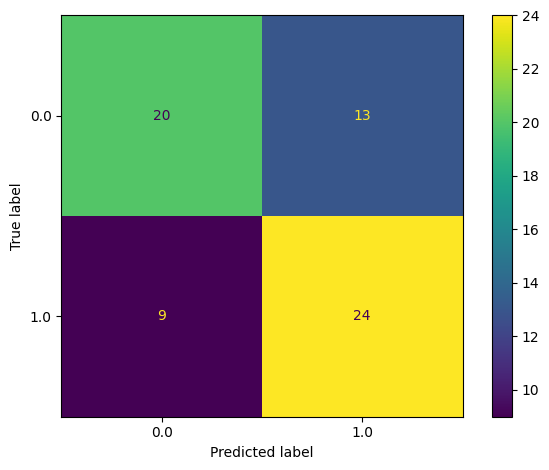

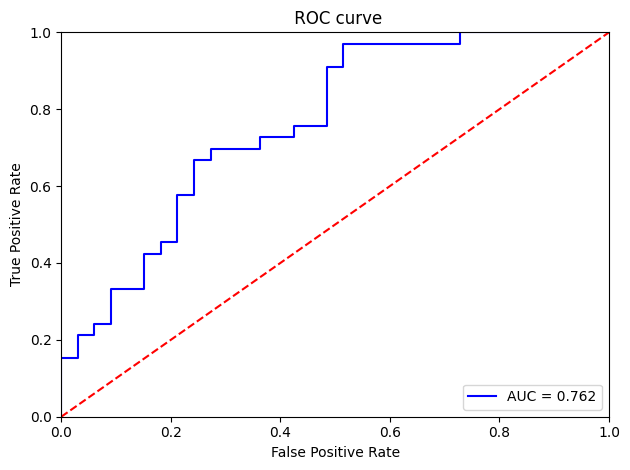

In [26]:
# load model
presaved_model = joblib.load(output_folder+"models/"+export_title+"SVM")
report_utils.classification_summary(y_valid, presaved_model.predict_proba(x_valid)[:, 1]) 